In [1]:
# %load 2_basic_example_G.py

import src.core as mlModule
model = 'A'

Using TensorFlow backend.


In [2]:
# File path to dataset .csv file
filename = "../master-thesis-db/datasets/G/data_30min.csv"

# List of columns on form ['name', 'description', 'unit']
columns = [
    ['PDI0064', 'Process Pressure Difference', 'Bar'],
    ['TI0066', 'Process Outlet Temperature','Degrees'],
    ['TZI0012', 'Process Inlet Temperature', 'Degrees'],
    ['FI0010', 'Process Flow Rate', 'Mm^3/day'],
    ['TT0025', 'Coolant Inlet Temperature', 'Degrees'],
    ['TT0026', 'Coolant Outlet Temperature', 'Degrees'],
    ['PI0001', 'Coolant Inlet Pressure', 'Bar'],
    ['FI0027', 'Coolant Flow Rate', 'Mm^3/day'],
    ['TIC0022U', 'Coolant Valve Opening', '%'],
    ['PDT0024', 'Coolant Pressure Difference', 'Bar'],
]

# List of column names to ignore completely
irrelevantColumns = [
	'PI0001',
	'FI0027',
	'TIC0022U',
	'PDT0024',
    'PDI0064',
]

# List of column names used a targets
targetColumns = [
	'TT0026',
]

# List of training periods on form ['start', 'end']
traintime = [
	["2019-04-24 00:00:00", "2019-08-01 00:00:00"]
]

# Testing period, recommended: entire dataset
testtime = [
	"2017-01-01 00:00:00",
	"2020-03-01 00:00:00",
]

In [3]:
df = mlModule.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlModule.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlModule.getFeatureTargetSplit(targetColumns)

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows



In [4]:
#mlp_1 = mlModule.MLP('MLP 1x64 d0.2 mod'+model, layers=[64], dropout=0.2)
mlp_2 = mlModule.MLP('MLP 1x128 d0.2 mod'+model, layers=[128], dropout=0.2)
#mlp_3 = mlModule.MLP('MLP 2x64 d0.2 mod'+model, layers=[64, 64], dropout=0.2)
#mlp_4 = mlModule.MLP('MLP 2x128 d0.2 mod'+model, layers=[128, 128], dropout=0.2)
#lstm_1 = mlModule.LSTM('LSTM 1x64 d0.2 mod'+model, layers=[64], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
lstm_2 = mlModule.LSTM('LSTM 1x128 d0.2 mod'+model, layers=[128], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
#lstm_3 = mlModule.LSTM('LSTM 2x64 d0.2 mod'+model, layers=[64, 64], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
#lstm_4 = mlModule.LSTM('LSTM 2x128 d0.2 mod'+model, layers=[128, 128], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
linear = mlModule.Linear_Regularized('Linear rCV mod'+model)
ensemble1 = mlModule.Ensemble('MLP 1x128 + Linear mod'+model, [mlp_2, linear])
ensemble2 = mlModule.Ensemble('LSTM 1x128 + Linear mod'+model, [lstm_2, linear])

modelList = [
    linear,
    #mlp_1,
    mlp_2,
    #mlp_3,
    #mlp_4,
    #lstm_1,
    lstm_2,
    #lstm_3,
    #lstm_4,
    ensemble1,
    ensemble2,
]

Training model Linear rCV modA
    Trained weights for Linear rCV modA:
[[ 0.26106655 -0.18036607 -0.74340497 -0.26854008]]
Model MLP 1x128 d0.2 modA was loaded from file
Model LSTM 1x128 d0.2 modA was loaded from file
Model MLP 1x128 + Linear modA was loaded from file
Training submodel Linear rCV modA of Ensemble MLP 1x128 + Linear modA
    Trained weights for Linear rCV modA:
[[ 0.26106655 -0.18036607 -0.74340497 -0.26854008]]
    Trained weights for Linear model of ensemble:
[[ 0.86654274 -0.04709632]]
Model LSTM 1x128 + Linear modA was loaded from file
Training submodel Linear rCV modA of Ensemble LSTM 1x128 + Linear modA
    Trained weights for Linear rCV modA:
[[ 0.26106655 -0.18036607 -0.74340497 -0.26854008]]
    Trained weights for Linear model of ensemble:
[[0.80829326 0.18524782]]
+----------------------+-----------+-------------+---------------+--------+
|        Model         | Min. loss | Chosen loss | Min. val loss | Epochs |
+----------------------+-----------+---------

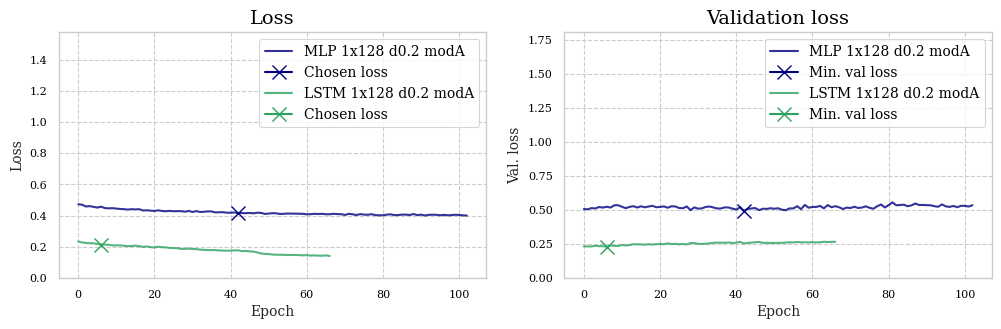

In [5]:
# Define whether to retrain models or not
retrain=False

mlModule.initModels(modelList)
mlModule.trainModels(retrain)

Model prediction scores
+--------------------------+-------------+------------+
|          Model           | Train score | Test score |
+--------------------------+-------------+------------+
|     Linear rCV modA      |    0.562    |  -1.2036   |
|   MLP 1x128 d0.2 modA    |    0.6775   |  -1.8049   |
|   LSTM 1x128 d0.2 modA   |    0.8797   |  -1.4088   |
| MLP 1x128 + Linear modA  |    0.6781   |  -1.8774   |
| LSTM 1x128 + Linear modA |    0.8973   |  -1.3442   |
+--------------------------+-------------+------------+


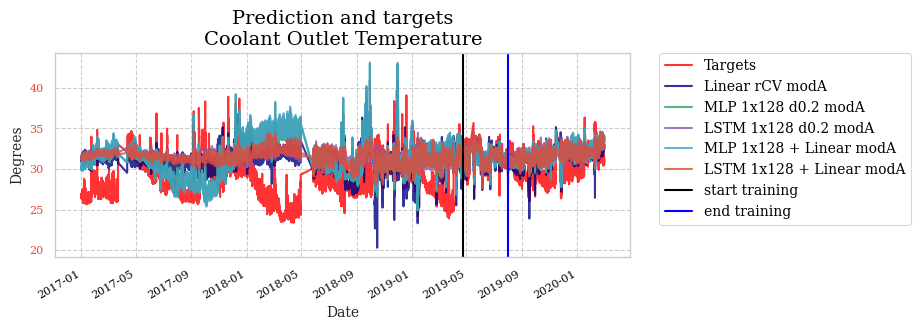

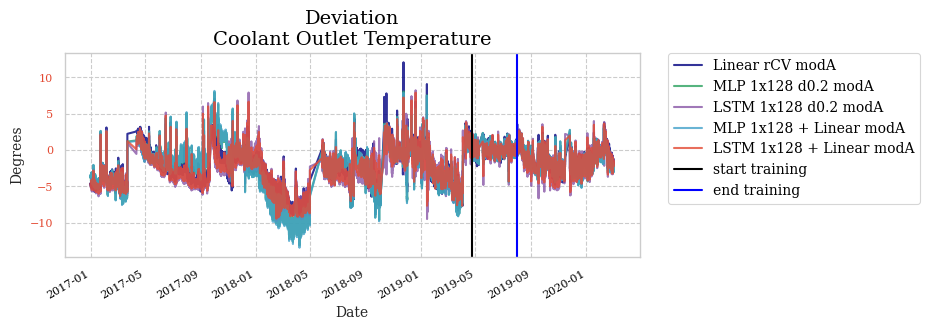

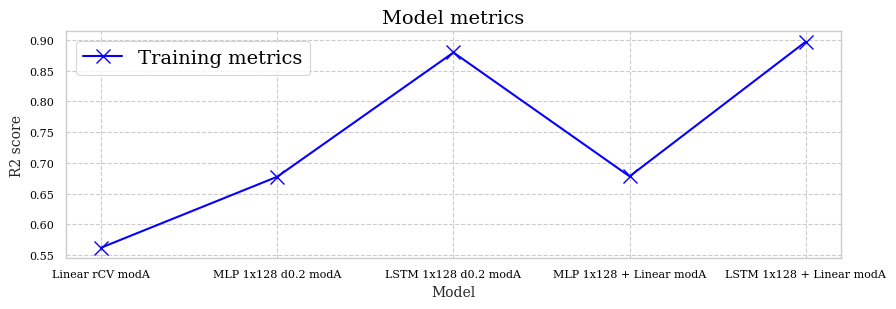

In [6]:
modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlModule.predictWithModels(
	plot=True,
	interpol=False,
	score=True,
)

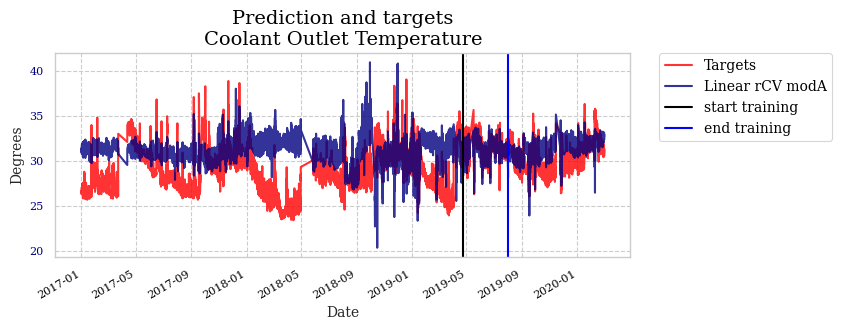

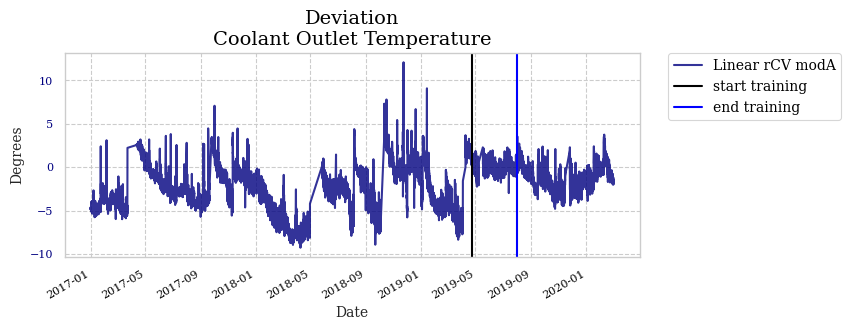

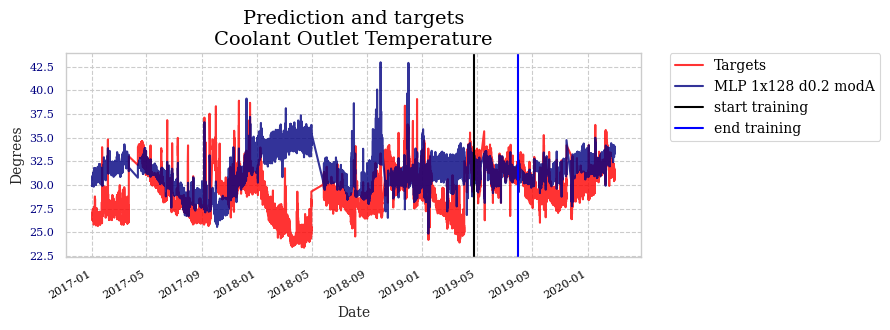

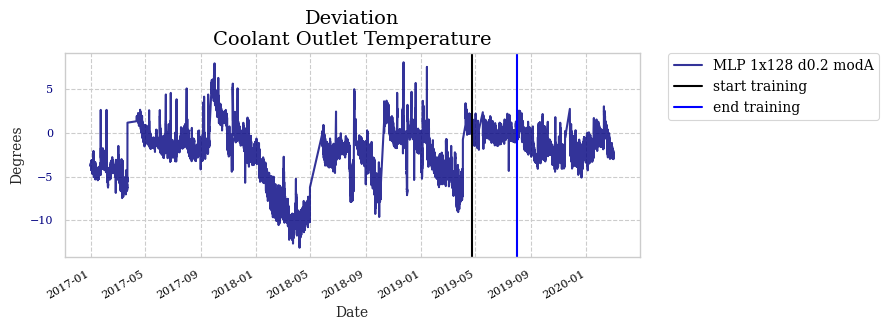

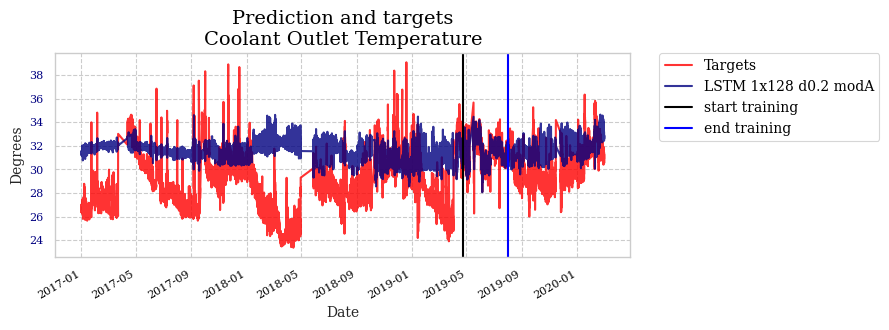

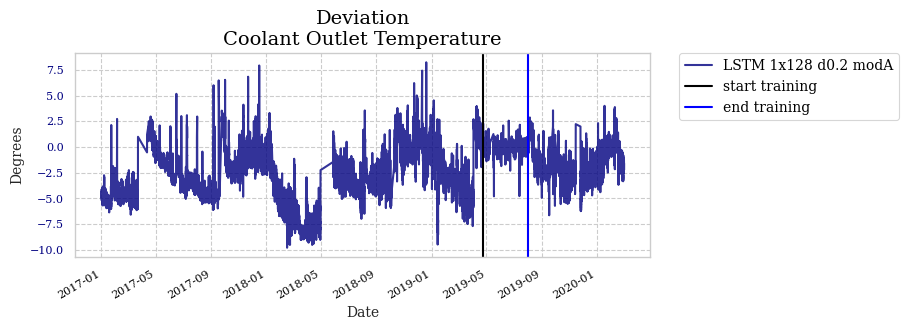

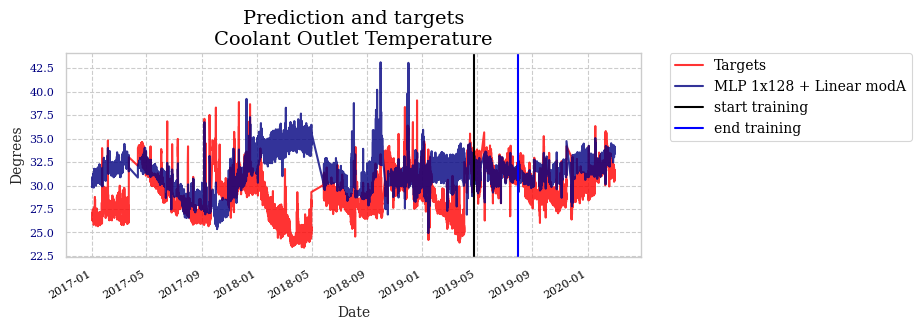

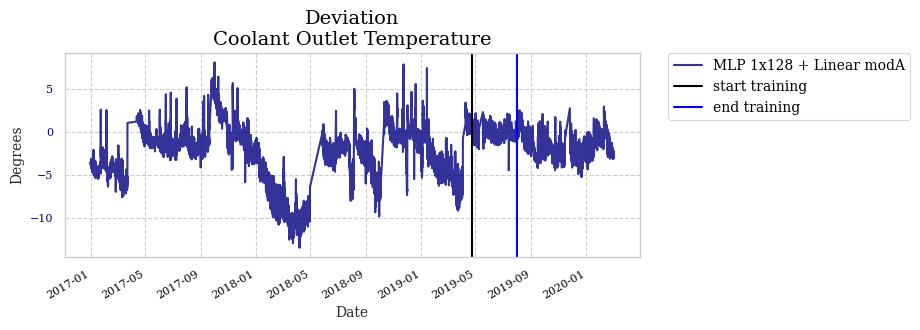

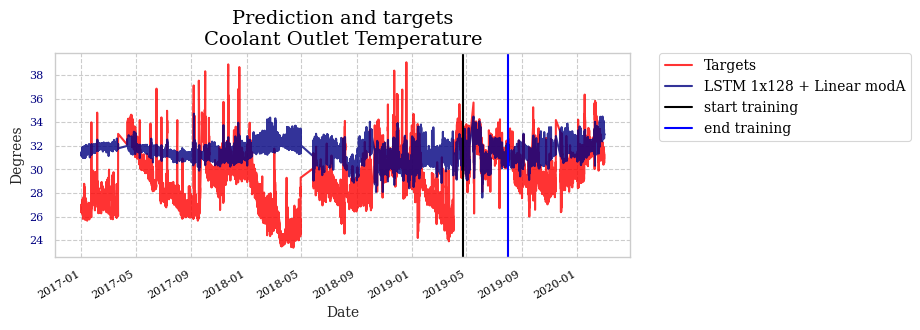

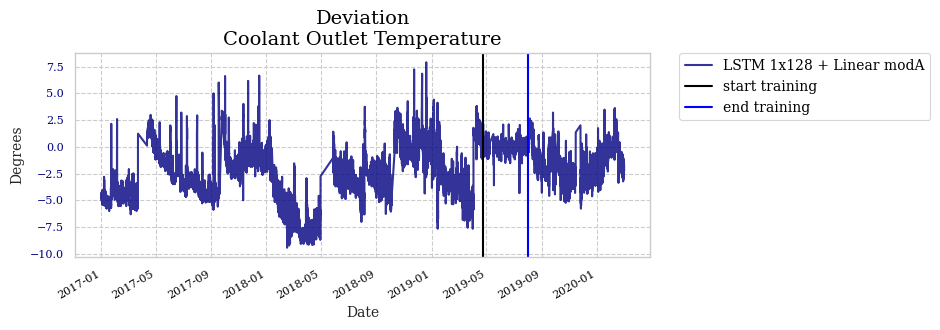

In [7]:
for model in modelList:
    mlModule.initModels([model])
    modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlModule.predictWithModels(
        plot=True,
        interpol=False,
        score=False,
    )